# Fully convolutional network for semantic segmentation

Semantic segmentation belongs to scene understanding field, and it is the task of assigning meaning to a part of an object. This can be done at the pixel level where we assign each pixel to a target class.

The goal is to input an image into a neural network and output a category for every pixel. We'll have a set of categories, much like in a classification task. But instead of assigning a single class to an image we want to assign a class to every pixel in that image.

FCNs achieves state-of-art in tasks like semantic segmentation, by taking advantage of three special techniques:
- Replace fully connected layers with one by one convolutional layer.
- Up-sampling through the use of transposed convolutional layers.
- Adding skip connections. (This allows the network to use information from multiple resolution scales)

This network takes in an image that has true labels attached to each pixel and then it outputs a tensor with dimension:``` classes x height x width. ```

**FCN limitations**

- It is very expensive to label every pixel.
- It is computationally expensive to maintain spatial information in each convolutional layer.

## Set up Google Colab

### Connect with Google drive 

In [ ]:
from google.colab import files
train = files.upload()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Go to the project directory

In [ ]:
%cd "/content/drive/My Drive/"
%ls

/content/drive/My Drive
 CamVid/                              loss.csv
'Case Study'/                         loss.npy
'Colab Notebooks'/                    MATLAB/
'Data Science'/                      'My Schedule.gsheet'
 Dissertation/                        Photo/
 fcn-model-50Epoch.pth                Presentation/
 fcn-model-55Epoch.pth                Proposal/
 fcn-model-meaniuo-50Epoch.pth        train_path2.csv
 fcn-model-meaniuo-55Epoch.pth        train_path2.gsheet
 Glasgow.rar                          Transcript.pdf
 Handycam/                            val_path2.csv
'How to get started with Drive.pdf'   val_path2.gsheet
 Law/                                 Video/


### Install packages

## Imports 

In [ ]:
%matplotlib inline 


import matplotlib.pyplot as plt
import numpy as np
from numpy import asarray
import pandas as pd
import scipy.misc
import imageio
import random

import torch
import torch.nn as nn
import torch.functional as F
from torch import optim

import torchvision
from torchvision import models, datasets, transforms, utils
from torchvision.models.vgg import VGG
from torch.utils.data import Dataset

import torch.utils.data as data
import glob
import cv2
import os
import io
from PIL import Image

from statistics import mean

#import albumentations as A
#from pytorch_toolbelt.utils import fs

## Data

[CamVid](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/) is a motion-based segmentation and recognition [dataset](https://github.com/mostafaizz/camvid) that contains 701 images, 701 labeled images, and a file with a list of classes with their correspondence in RGB code. 

**NOTE:** 
I pre-processed the labeled images by changing their RGB values for class ids. Instead of doing it directly on the CamVid class, do it separately and save the result as a .npy file to improve the performance ([Here](https://towardsdatascience.com/why-you-should-start-using-npy-file-more-often-df2a13cc0161) is an interesting article about that). In this way you cannot use PyTorch transforms on a label image, since PIL will change the class id for color values. Also, CamVid images are very similar, so adding augmentation like RandomCrop or RandomHorizontalFlip helps the network.

### Load data

In [ ]:
class CamVid(Dataset):
  
  def __init__(self, csv_file, phase):
    self.phase = phase
    self.data = pd.read_csv(csv_file)
    
    if phase == 'train':
        self.input_shape = (640, 768)
    elif phase == 'valid':
        self.input_shape = (640, 896)
  
  def __getitem__(self, index):
    image, label = self.data.iloc[index, 1], self.data.iloc[index, 2]
    image = imageio.imread(image,pilmode="RGB")
    label = np.load(label)
        
    if self.phase == "train":
         # RandomCrop
        h, w, _ = image.shape
        new_h, new_w = self.input_shape
        top = random.randint(0, h - new_h)
        left = random.randint(0, w - new_w)
        image = image[top:top + new_h, left:left + new_w]
        label = label[top:top + new_h, left:left + new_w]
      
      # RandomHorizontalFlip
    if random.random() < 0.5:
        image = np.fliplr(image)
        label = np.fliplr(label)
        
    if self.phase == "valid":
      # "Resize"
        new_h, new_w = self.input_shape
        image = image[0:new_h, 0:new_w]
        label = label[0:new_h, 0:new_w]
          
    # Normalization 
    mean=[0.485, 0.456, 0.460]
    std =[0.229, 0.224, 0.225]
    
    image = np.transpose(image, (2, 0, 1)) / 255.
    image[0] = (image[0] - mean[0]) / std[0]
    image[1] = (image[1] - mean[1]) / std[1]
    image[2] = (image[2] - mean[2]) / std[2]
    
    # ToTensor 
    image = torch.from_numpy(image.copy()).float()
    label = torch.from_numpy(label.copy()).long()
  
    # One-hot encoding 
    h, w = label.size()
    target = torch.zeros(32, h, w)
    for c in range(32):
        target[c][label == c] = 1
        
    return {'x': image, 'y':target, 'l':label} 

  def __len__(self):
    return len(self.data) 

In [ ]:
train_data = CamVid("/content/drive/My Drive/train_path2.csv", phase="train")
valid_data = CamVid("/content/drive/My Drive/val_path2.csv", phase="valid")

trainloader = torch.utils.data.DataLoader(train_data, batch_size=5, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=1)

### Visualize a single batch

torch.Size([5, 3, 640, 768]) torch.Size([5, 32, 640, 768]) torch.Size([5, 640, 768])


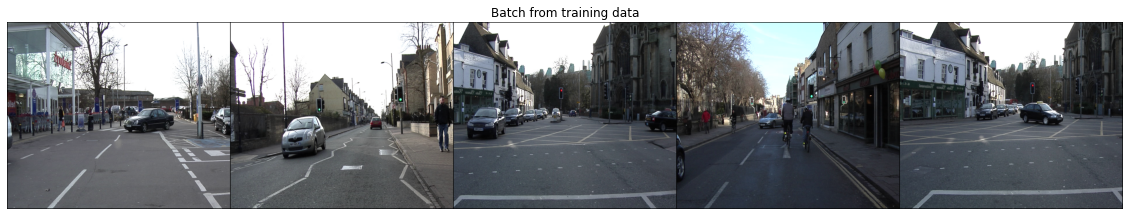

In [ ]:
def show_batch(batch):
  mean=[0.485, 0.456, 0.460]
  std =[0.229, 0.224, 0.225]
  
  img_batch = batch['x']
 
  # Desnormalize 
  img_batch[:,0,...].mul_(std[0]).add_(mean[0])
  img_batch[:,1,...].mul_(std[1]).add_(mean[1])
  img_batch[:,2,...].mul_(std[2]).add_(mean[2])
  
  img_batch = np.clip(img_batch, 0, 1)
  grid = utils.make_grid(img_batch)
  
  plt.rcParams['figure.figsize'] = [20, 7.0]
  plt.figure()
  plt.title('Batch from training data')
  plt.imshow(grid.numpy().transpose((1, 2, 0)))
  plt.axis('off')
  plt.ioff()
  plt.show
    
batch = next(iter(trainloader))
print(batch['x'].size(), batch['y'].size(), batch['l'].size())
show_batch(batch)

## Model

### Encoder 

Its goal is to extract features from the image. In this case, I used the pretrained VGG16 model and removed the classifier (the fully connected layer at the end).  Doing so casts it into a fully convolutional network that outputs classification maps (heatmaps). Also saved the score of three different pooling layers that the decoder will use to perform skip connections.

In [ ]:
class VGG16(VGG):
  
  def __init__(self, cfg, ranges, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
    super().__init__(self.make_layers(cfg[model]))
    
    self.ranges = ranges[model]
        
    if pretrained:
      exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model) #Loading all weights 
    if not requires_grad:
      for parameter in super().parameters(): # False if you want to freeze the encoder and avoid to train it.
        parameter.requires_grad = False
    if remove_fc: 
      del self.classifier
      del self.avgpool
    if show_params:  # Display the params to see the dimensionallity
      for name, parameter in self.named_parameters():
        print(name, parameter.size())
        
  def forward(self, x):
    output = {}
    
    # Get the output of each maxpooling layer (There are 5 in VGG) to create skip connections.
    for idx in range(len(self.ranges)): #range is below the decoder: ranges = {'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31))}
      for layer in range(self.ranges[idx][0], self.ranges[idx][1]):
        x = self.features[layer](x)
      output["pool%d"%(idx+1)] = x #naming the layer:pool(index+1)
    
    return output 
  
  def make_layers(self, cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:   #cfg = {'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],}
      if v == 'M':
        layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
      else:
        conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
        if batch_norm:
          layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
        else:
          layers += [conv2d, nn.ReLU(inplace=True)]
        in_channels = v
    return nn.Sequential(*layers)

In [ ]:
ranges = {'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31))} #up to each maxpooling layer
cfg = {'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],}

In [ ]:
VGG16(cfg,ranges)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

### Decoder 

It up-scales the output of the encoder such that it's the same size as the original image.

- **Convolutional score layer** - This will result in the output of a 4D tensor instead of a flattened 2D tensor, so spatial information will be preserved. Effectively, this turns convolutions into a matrix multiplication with spatial information. The number of kernels is equivalent to the number of outputs. 

- **Transposed convolutions** - Is essentially a reverse convolution in which the forward and the backward passes are swapped. They help in upsampling the previous layer to a higher resolution or dimension.  

- **Skip connections** - They allow the network to use information from multiple resolutions, and as a result, the network is able to make more precise segmentation decisions.

In [ ]:
class FCN8s(nn.Module):
  
  def __init__(self, pretrained_model, n_classes):
    super().__init__()
    
    self.n_classes = n_classes
    self.pretrained_model = pretrained_model
    #Convolutional layers
    self.relu = nn.ReLU(inplace=True)

    #Extra layers
    self.conv1= nn.Conv2d(512,576,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    self.conv2= nn.Conv2d(576,576,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    self.conv3= nn.Conv2d(576,576,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    self.pool6= nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    
    self.conv4= nn.Conv2d(576,576,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    self.conv5= nn.Conv2d(576,576,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    self.conv6= nn.Conv2d(576,576,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    self.pool7= nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

    self.conv7 = nn.Conv2d(in_channels=576, out_channels=4096, kernel_size=7, padding=3)
    self.dropout1 = nn.Dropout(0.85)

    self.conv8 = nn.Conv2d(in_channels=4096, out_channels=4096, kernel_size=1)
    self.dropout2 = nn.Dropout(0.85)

    self.conv9 = nn.Conv2d(in_channels=4096, out_channels=n_classes, kernel_size=1)
    
    # Transposed convolutions (to upsampling previous layers)
    self.deconv1 = nn.ConvTranspose2d(in_channels=n_classes, out_channels=576, kernel_size=4, stride=2, padding=1)
    self.bn1 = nn.BatchNorm2d(576)
    self.deconv2 = nn.ConvTranspose2d(in_channels=576, out_channels=512, kernel_size=4, stride=2, padding=1)
    self.bn2 = nn.BatchNorm2d(512)
    self.deconv3 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1)
    self.bn3 = nn.BatchNorm2d(512)
    self.deconv4 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1)
    self.bn4 = nn.BatchNorm2d(256)
    self.deconv5 = nn.ConvTranspose2d(in_channels=256, out_channels=n_classes, kernel_size=16, stride=8, padding=4)
    self.bn5 = nn.BatchNorm2d(n_classes)
    # Convolutional score layer (replace the FC layers)
    self.score = nn.Conv2d(n_classes, n_classes, 1)
  
  def forward(self, x):
    x = self.pretrained_model(x)
    
    # Skip connections (connect the output of one layer to a non-adjacent layer)
    pool_5 = x['pool5']
    pool_4 = x['pool4']
    pool_3 = x['pool3']
    
    x = self.relu(self.conv1(pool_5))
    x = self.relu(self.conv2(x))
    x = self.relu(self.conv3(x))
    pool_6 =self.pool6(x)

    x = self.relu(self.conv4(pool_6))
    x = self.relu(self.conv5(x))
    x = self.relu(self.conv6(x))
    pool_7 =self.pool7(x)
    
    x = self.dropout1(self.relu(self.conv7(pool_7)))
    x = self.dropout2(self.relu(self.conv8(x)))
    x = self.relu(self.conv9(x))

    x = self.relu(self.deconv1(x))
    x = self.bn1(x + pool_6)
    x = self.relu(self.deconv2(x))
    x = self.bn2(x + pool_5)
    x = self.relu(self.deconv3(x))
    x = self.bn3(x + pool_4)
    x = self.relu(self.deconv4(x))
    x = self.bn4(x + pool_3)
    x = self.bn5(self.relu(self.deconv5(x)))
    x = self.score(x)
    
    return x

###  Test output sizes

In [ ]:
batch_size, n_classes, h, w = 4, 20, 640, 768

encoder = VGG16(cfg, ranges, requires_grad=True)
decoder = FCN8s(encoder, n_classes)

enc_input = torch.randn(batch_size, 3, 160, 160)
dec_input = torch.randn(batch_size, 3, h, w)

enc_output = encoder(enc_input)
dec_output = decoder(dec_input)

assert enc_output['pool5'].size() == torch.Size([batch_size, 512, 5, 5])
assert dec_output.size() == torch.Size([batch_size, n_classes, h, w])
print("Correct output sizes")

Correct output sizes


## Train model

### Test if the model works using a single batch

In [ ]:
fcn = FCN8s(VGG16(cfg,ranges), n_classes)
fcn

FCN8s(
  (pretrained_model): VGG16(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
 

In [ ]:
#fcn.pretrained_model.features[0]=nn.Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [ ]:
fcn = FCN8s(VGG16(cfg,ranges), n_classes)

criterion = nn.BCELoss()
optimizer = optim.SGD(fcn.parameters(), lr=0.01, momentum=0.9)

x = torch.randn(batch_size, 3, h, w)
y = torch.randn(batch_size, n_classes, h, w)
y = torch.tensor(y, requires_grad=False)

for i in range(3):
  optimizer.zero_grad()
  output = fcn(x)
  output = torch.sigmoid(output)
  loss = criterion(output, y)
  loss.backward()
  print("i: {}, loss: {:.5f}".format(i, loss.item()))
  optimizer.step()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


i: 0, loss: 0.75276
i: 1, loss: 0.75258
i: 2, loss: 0.75222


### Set training parameters

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda', index=0)

In [ ]:
# Define model
n_classes = 32
model = FCN8s(VGG16(cfg, ranges), n_classes)

#state_dict = torch.load("/content/drive/My Drive/fcn-model.pth")
#model.load_state_dict(state_dict)

model.to(device)

# Define training parameters
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.0001, momentum=0, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.5)
epochs = 65
print_every = 20

# Define scores
IoU_scores = np.zeros((epochs, n_classes))
pixel_scores = np.zeros(epochs)

### Check accuracy before training

In [ ]:
def iou(y_hat, y):
  ious = []
  for c in range(n_classes):
    pred_inds = y_hat == c
    target_inds = y == c
    intersection = pred_inds[target_inds].sum() # the intersection based of false or true scale which if pred=true and inds=false then the outcome would be empty and summing up elements to get the number of intersction points (True)
    union = pred_inds.sum() + target_inds.sum() - intersection
    if union == 0:
      ious.append(float('nan')) # If there is no ground truth, do not include in evaluation
    else:
      ious.append(float(intersection) / float(max(union, 1)))
  return ious

def pixel_accuracy(y_hat, y):
  correct = (y_hat == y).sum()
  total = (y == y).sum()
  return correct/total


def validation(model, validloader, criterion):
  total_ious = []
  pixel_accs = []
  for i, batch in enumerate(validloader):
    inputs = batch['x'].to(device)
    output = model(inputs)
    output = output.data.cpu().numpy()
        
    N, _, h, w = output.shape 
    pred = output.transpose(0, 2, 3, 1).reshape(-1, n_classes).argmax(axis=1).reshape(N, h, w) #transposing 32 class at the end and reshape it to collect all data in 32 classes then taking maximum value of each class
    target = batch['l'].cpu().numpy().reshape(N, h, w)
    
    for y_hat, y in zip(pred, target):
      total_ious.append(iou(y_hat, y))
      pixel_accs.append(pixel_accuracy(y_hat, y))
  
  # Pixel accuracy
  pixel_acc = np.array(pixel_accs).mean()
  
  # Mean IoU
  total_ious = np.array(total_ious).T
  mean_iou = np.nanmean(np.nanmean(total_ious, axis=1))
  
  return pixel_acc, mean_iou

In [ ]:
model.eval()
with torch.no_grad():
  pixel_acc, mean_iou = validation(model, validloader, criterion)

print("Pixel accuracy: ", pixel_acc, " Mean IoU: ", mean_iou)

Pixel accuracy:  0.012194577612058078  Mean IoU:  0.0034895521751967255


### Train

In [ ]:
train_losses=[]
train_losses_epoch=[]
valid_losses=[]
valid_losses_epoch=[]
meaniou_epoch=[]
for epoch in range(epochs):
  for i, batch in enumerate(trainloader):
    inputs_trn, labels_trn = batch['x'].to(device), batch['y'].to(device)
    
    model.train()
    optimizer.zero_grad()
    
    trn_outputs = model.forward(inputs_trn)
    trn_loss = criterion(trn_outputs, labels_trn)
    train_losses.append(trn_loss.item())
    trn_loss.backward()
    optimizer.step()
    if i % print_every == 0:
      print("Epoch: {}/{}.. ".format(epoch+1, epochs),
            "Training loss: {:.5f}.. ".format(trn_loss.item()))
  
  train_losses_epoch.append(mean(train_losses))
  train_losses=[]   
  
  model.eval()
  with torch.no_grad():
     paccuracy, meaniou = validation(model, validloader, criterion)
     for i, batch in enumerate(validloader):
       inputs_val, labels_val = batch['x'].to(device), batch['y'].to(device)
       val_outputs = model.forward(inputs_val)
       val_loss = criterion(val_outputs, labels_val)
       valid_losses.append(val_loss.item())
       
  valid_losses_epoch.append(mean(valid_losses))
  meaniou_epoch.append(meaniou)    
  print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Validation loss: {:.5f}.. ".format(mean(valid_losses)),
              "Pixel accuracy.. {:.5f}".format(paccuracy),
              "Mean IU.. {:.5f}".format(meaniou))
  valid_losses=[] 


#Saving parameters
torch.save(model.state_dict(), "/content/drive/My Drive/fcn-model-modified_architecture1.2_65epoch.pth")
pd.DataFrame(train_losses_epoch).to_csv("/content/drive/My Drive/trn_loss_modified_architecture1.2_65epoch.csv",index=False)
pd.DataFrame(valid_losses_epoch).to_csv("/content/drive/My Drive/val_loss_modified_architecture1.2_65epoch.csv",index=False)
pd.DataFrame(meaniou_epoch).to_csv("/content/drive/My Drive/meaniou_modified_architecture1.2_65epoch.csv",index=False)

Epoch: 1/65..  Training loss: 0.73009.. 
Epoch: 1/65..  Training loss: 0.66950.. 
Epoch: 1/65..  Training loss: 0.65896.. 
Epoch: 1/65..  Training loss: 0.65025.. 
Epoch: 1/65..  Validation loss: 0.65574..  Pixel accuracy.. 0.74548 Mean IU.. 0.10431
Epoch: 2/65..  Training loss: 0.65349.. 
Epoch: 2/65..  Training loss: 0.64077.. 
Epoch: 2/65..  Training loss: 0.63568.. 
Epoch: 2/65..  Training loss: 0.63379.. 
Epoch: 2/65..  Validation loss: 0.63544..  Pixel accuracy.. 0.75929 Mean IU.. 0.12210
Epoch: 3/65..  Training loss: 0.63065.. 
Epoch: 3/65..  Training loss: 0.62711.. 
Epoch: 3/65..  Training loss: 0.62424.. 
Epoch: 3/65..  Training loss: 0.62153.. 
Epoch: 3/65..  Validation loss: 0.61703..  Pixel accuracy.. 0.83213 Mean IU.. 0.15627
Epoch: 4/65..  Training loss: 0.61967.. 
Epoch: 4/65..  Training loss: 0.61181.. 
Epoch: 4/65..  Training loss: 0.61370.. 
Epoch: 4/65..  Training loss: 0.60824.. 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice


Epoch: 4/65..  Validation loss: 0.60353..  Pixel accuracy.. 0.81373 Mean IU.. 0.15642
Epoch: 5/65..  Training loss: 0.60131.. 
Epoch: 5/65..  Training loss: 0.59959.. 
Epoch: 5/65..  Training loss: 0.59627.. 
Epoch: 5/65..  Training loss: 0.58880.. 
Epoch: 5/65..  Validation loss: 0.59920..  Pixel accuracy.. 0.80155 Mean IU.. 0.14629
Epoch: 6/65..  Training loss: 0.59212.. 
Epoch: 6/65..  Training loss: 0.58125.. 
Epoch: 6/65..  Training loss: 0.57609.. 
Epoch: 6/65..  Training loss: 0.57365.. 
Epoch: 6/65..  Validation loss: 0.57786..  Pixel accuracy.. 0.74976 Mean IU.. 0.13589
Epoch: 7/65..  Training loss: 0.56880.. 
Epoch: 7/65..  Training loss: 0.56494.. 
Epoch: 7/65..  Training loss: 0.55688.. 
Epoch: 7/65..  Training loss: 0.55512.. 
Epoch: 7/65..  Validation loss: 0.55324..  Pixel accuracy.. 0.84238 Mean IU.. 0.19093
Epoch: 8/65..  Training loss: 0.54957.. 
Epoch: 8/65..  Training loss: 0.54327.. 
Epoch: 8/65..  Training loss: 0.54479.. 
Epoch: 8/65..  Training loss: 0.53703.. 


### Check accuracy after training 

In [ ]:
model.eval()
with torch.no_grad():
  pixel_acc, mean_iou = validation(model, validloader, criterion)

print("Pixel accuracy: ", pixel_acc, " Mean IoU: ", mean_iou)

Pixel accuracy:  0.9014587490417569  Mean IoU:  0.32920787048885825


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice


Visulization

In [ ]:
#Training Loss
pd.read_csv("/content/drive/My Drive/trn_loss_modified_architecture1.2_65epoch.csv")

In [ ]:
#Validation Loss
pd.read_csv("/content/drive/My Drive/val_loss_modified_architecture1.2_65epoch.csv")

In [ ]:
#Mean IOU
pd.read_csv("/content/drive/My Drive/meaniou_modified_architecture1.2_65epoch.csv")

Training Loss PLot

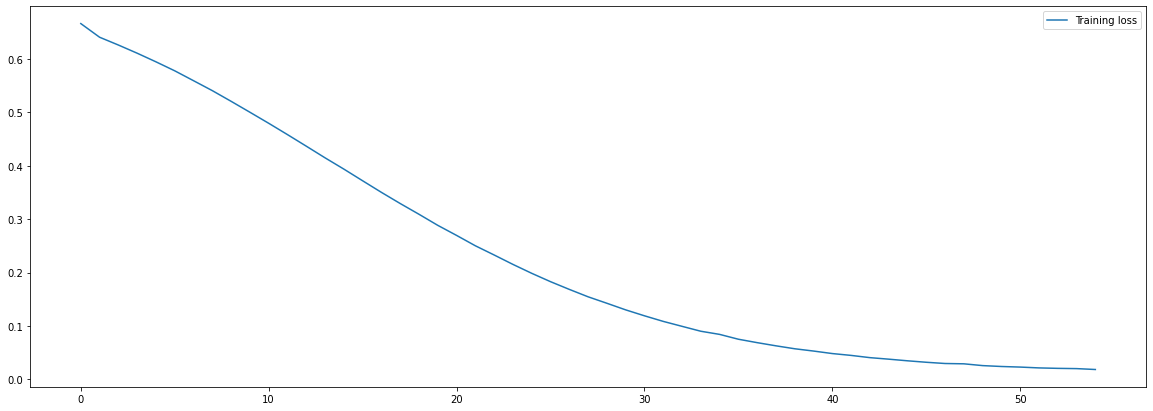

In [ ]:
plt.plot(train_losses_epoch, label='Training loss')
plt.legend()
plt.show()

## Make inference

In [ ]:
n_classes = 32
model = FCN8s(VGG16(cfg, ranges), n_classes)
state_dict = torch.load("/content/drive/My Drive/fcn-model-modified_architecture1.2_65epoch.pth")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
def plot_imgs(images = [], titles = [], figsize = (10,10)):
  size = len(images)
  fig = plt.figure(figsize=figsize)
  i = 1
  for image in images:
    ax = fig.add_subplot(1,size,i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i-1])
    ax.imshow(image)
    i += 1
  return None
  
#Id : [Label, (RGB code)]
gt_labels = {1 : ["Animal", (64, 128, 64)],
            2 : ["Archway", (192, 0, 128)],
            3 : ["Bicyclist", (0, 128, 192)],
            4 : ["Bridge", (0, 128, 64)],
            5 : ["Building", (128, 0, 0,)],
            6 : ["Car", (64, 0, 128)],
            7 : ["CartLuggagePram", (64, 0, 192)],
            8 : ["Child", (192, 128, 64)],
            9 : ["Column_Pole", (192, 192, 128)],
            10: ["Fence", (64, 64, 128)],
            11: ["LaneMkgsDriv", (128, 0, 192)],
            12: ["LaneMkgsNonDriv", (192, 0, 64)],
            13: ["Misc_Text", (128, 128, 64)],
            14: ["MotorcycleScooter", (192, 0, 192)],
            15: ["OtherMoving", (128, 64, 64)],
            16: ["ParkingBlock", (64, 192, 128)],
            17: ["Pedestrian", (64, 64, 0)],
            18: ["Road", (128, 64, 128)],
            19: ["RoadShoulder", (128, 128, 192)],
            20: ["Sidewalk", (0, 0, 192)],
            21: ["SignSymbol", (192, 128, 128)],
            22: ["Sky", (128, 128, 128)],
            23: ["SUVPickupTruck", (64, 128, 192)],
            24: ["TrafficCone", (0, 0, 64)],
            25: ["TrafficLight", (0, 64, 64)],
            26: ["Train", (192, 64, 128)],
            27: ["Tree", (128, 128, 0)],
            28: ["Truck_Bus", (192, 128, 192)],
            29: ["Tunnel", (64, 0, 64)],
            30: ["VegetationMisc", (192, 192, 0)],
            31: ["Void", (0, 0, 0)],
            32: ["Wall", (64, 192, 0)]}	

In [ ]:
from PIL import Image
import warnings

warnings.filterwarnings("ignore")

inference_transforms = transforms.Compose([ transforms.Resize((640, 896)),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.460],[0.229, 0.224, 0.225])])
def load_image(image):
  if isinstance(image, str):
    image = Image.open(image).convert('RGB')
  else:
    image = Image.fromarray(image).convert('RGB')
  image = inference_transforms(image)
  image = torch.tensor(image, requires_grad=False)
  image = image.unsqueeze(0)
  return image

def get_predicted_image(original, prediction, labels=None):
  _, h, w = prediction.shape
  _, oh, ow = original.shape
  if h != oh or w != ow:
    original =np.array(Image.fromarray(original).resize(size=(640, 896))) #scipy.misc.imresize(original, (640, 896))
  output = np.zeros((h, w, 3), dtype=np.uint8)
  for i in range(h):
    for j in range(w):
      index = prediction[0][i][j] + 1
      try:
        if labels is not None:
          if index in labels:
            color = gt_labels.get(index)[1]
            output[i, j, 0] = color[0]
            output[i, j, 1] = color[1]
            output[i, j, 2] = color[2]
          else:
            output[i, j, 0] = original[i, j, 0]
            output[i, j, 1] = original[i, j, 1]
            output[i, j, 2] = original[i, j, 2]
        else:
          color = gt_labels.get(index)[1]
          output[i, j, 0] = color[0]
          output[i, j, 1] = color[1]
          output[i, j, 2] = color[2]
      except:
        print("Upss, didn't work")
        break
  return output

def get_image_labels(testimage):
  model.to(device)
  model.eval()
  image = load_image(testimage)
  prediction = model(image.to(device))
  prediction = prediction.data.cpu().numpy()
  N, _, h, w = prediction.shape
  prediction = prediction.transpose(0, 2, 3, 1).reshape(-1, 32).argmax(axis=1).reshape(N, h, w)
  return prediction

### Compare prediction with ground truth

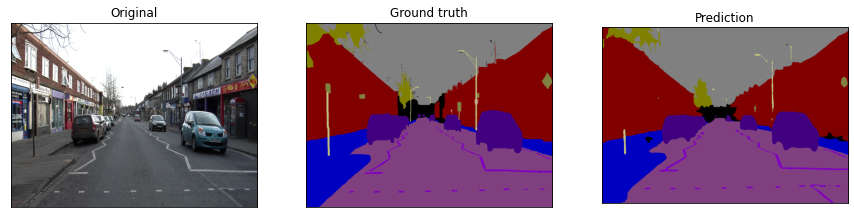

In [ ]:
name = "Seq05VD_f04050"

inp_image = "/content/drive/My Drive/CamVid/train/" + name + ".png"
tru_image = "/content/drive/My Drive/CamVid/train_labels/" + name + "_L.png"

original = imageio.imread(inp_image)
truth = imageio.imread(tru_image)
predicted = get_predicted_image(original, get_image_labels(inp_image))

plot_imgs([original, truth, predicted], ["Original", "Ground truth", "Prediction"], (15, 15))

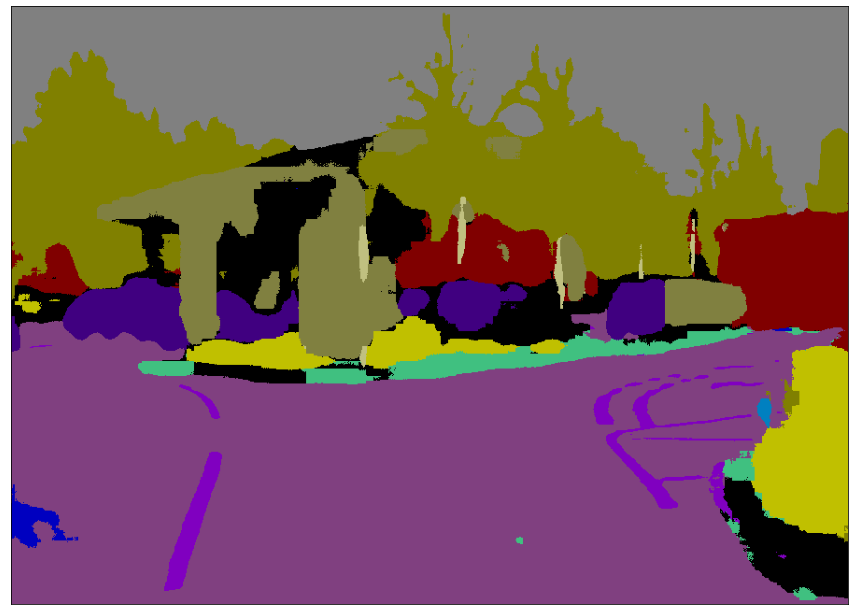

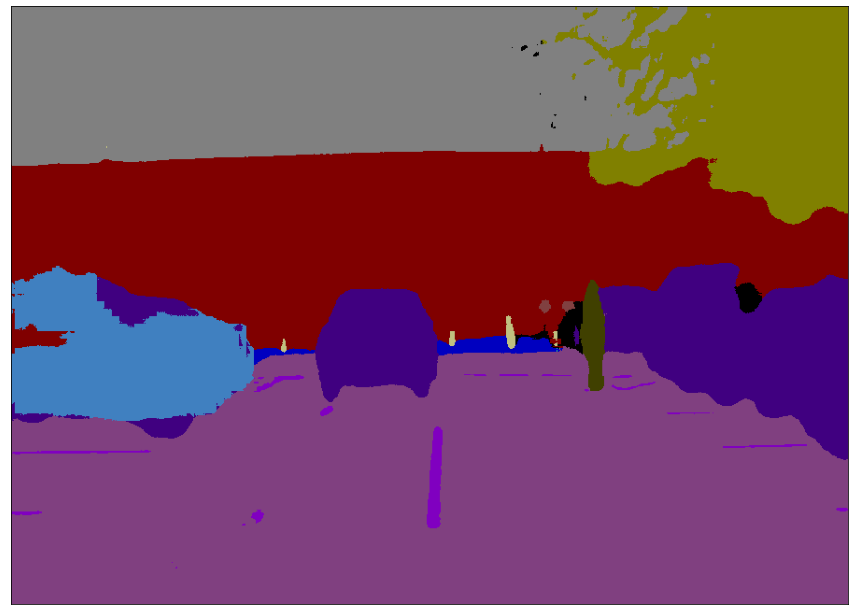

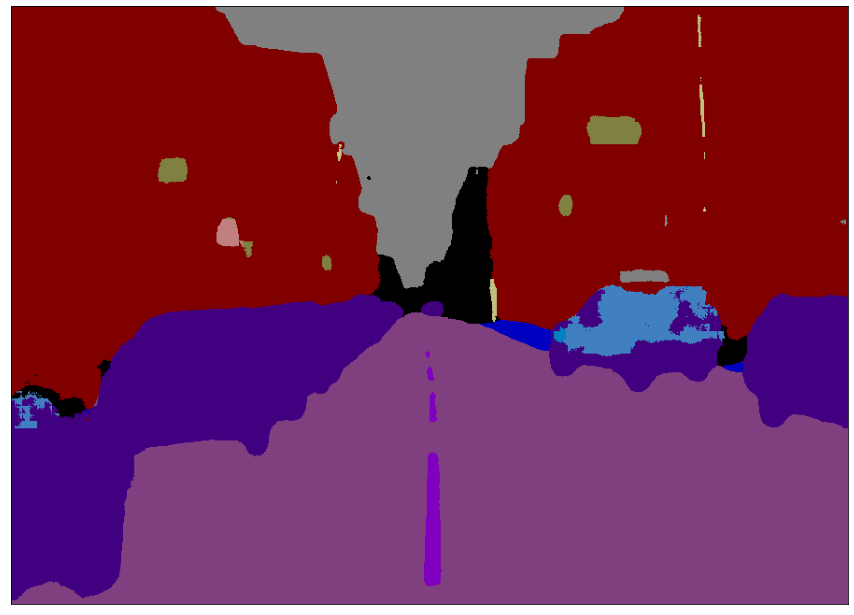

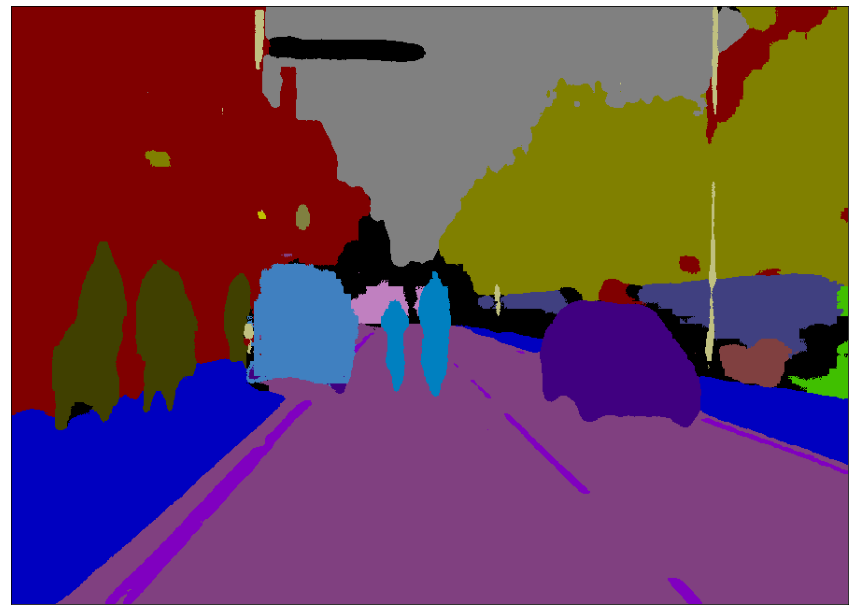

In [ ]:
name = ["0006R0_f01920","0006R0_f02790","0016E5_06330","0016E5_07800"]
for nam in name:
  inp_image = "/content/drive/My Drive/CamVid/val/" + nam + ".png"
  #tru_image = "/content/drive/My Drive/CamVid/val_labels/" + nam + "_L.png"

  prd=get_predicted_image(imageio.imread(inp_image), get_image_labels(inp_image))
  plot_imgs([prd], [""], (15, 15))

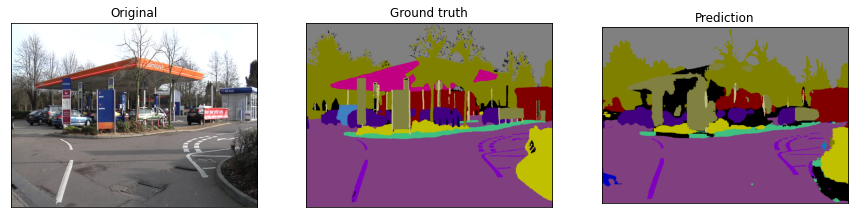

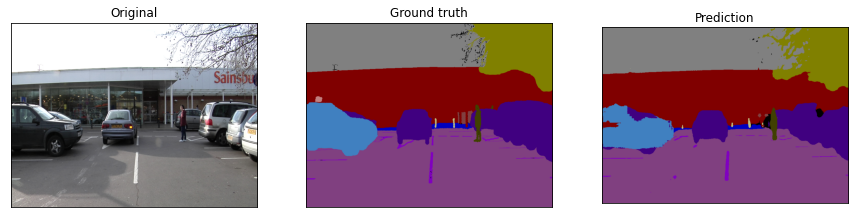

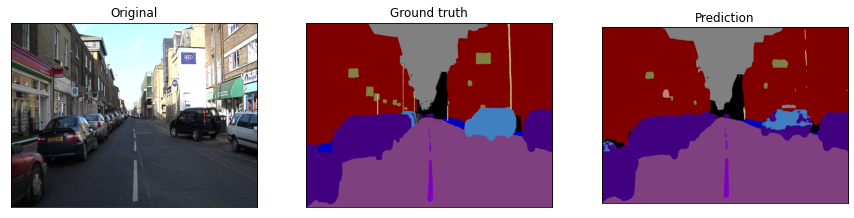

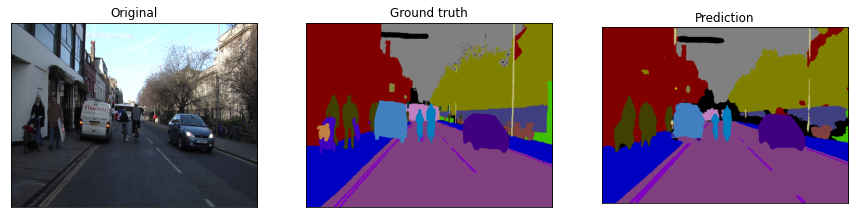

In [20]:
name = ["0006R0_f01920","0006R0_f02790","0016E5_06330","0016E5_07800"]
for nam in name:
  inp_image = "/content/drive/My Drive/CamVid/val/" + nam + ".png"
  tru_image = "/content/drive/My Drive/CamVid/val_labels/" + nam + "_L.png"

  original = imageio.imread(inp_image)
  truth = imageio.imread(tru_image)
  predicted = get_predicted_image(original, get_image_labels(inp_image))

  plot_imgs([original, truth, predicted], ["Original", "Ground truth", "Prediction"], (15, 15))

### Predict on an unlabeled image 

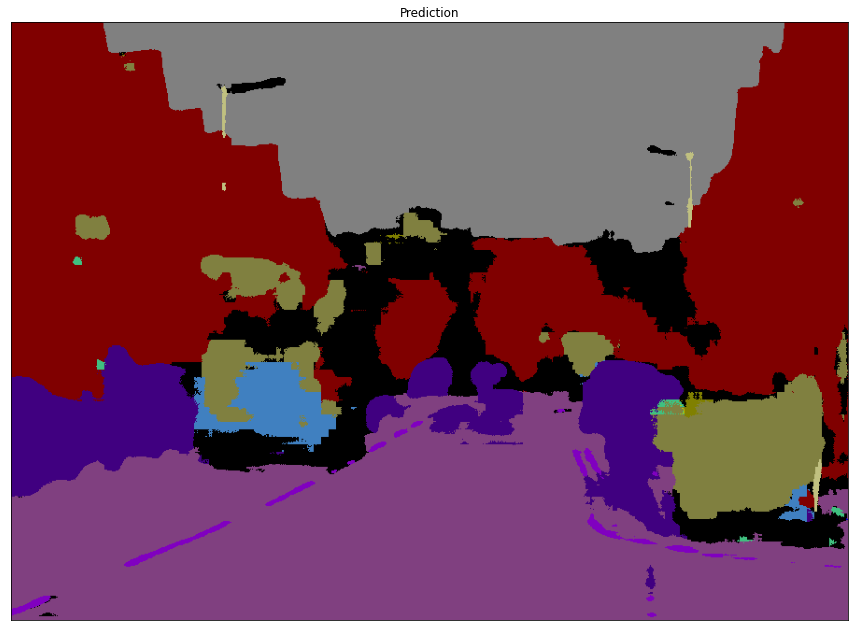

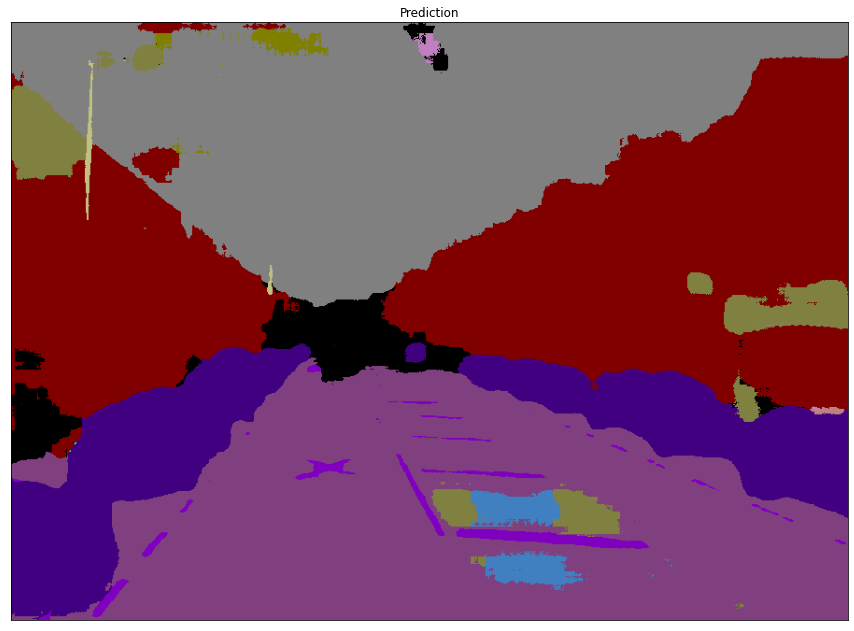

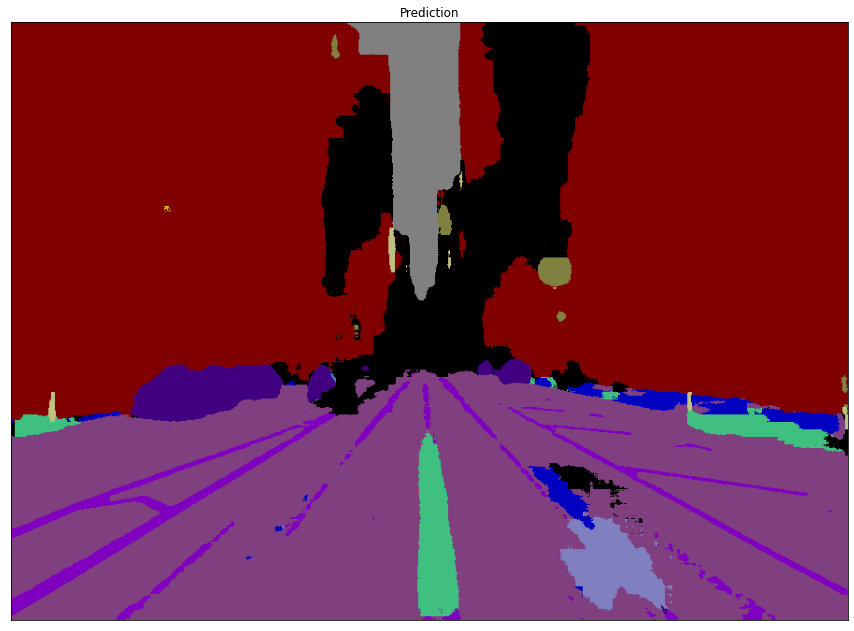

In [21]:
name = ["/content/drive/My Drive/CamVid/City_Road_Cardiff.jpg",
        "/content/drive/My Drive/CamVid/City-Road-in-Cardiff2.jpg",
        "/content/drive/My Drive/CamVid/Road US.jpg"]
for inp_image in name:

  prd=get_predicted_image(imageio.imread(inp_image), get_image_labels(inp_image))
  plot_imgs([prd], ["Prediction"], (15, 15))

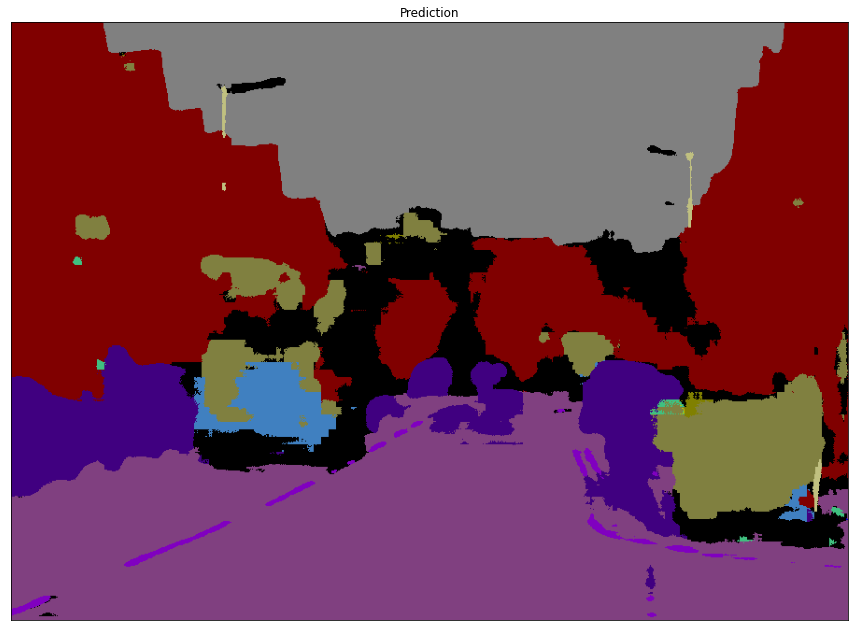

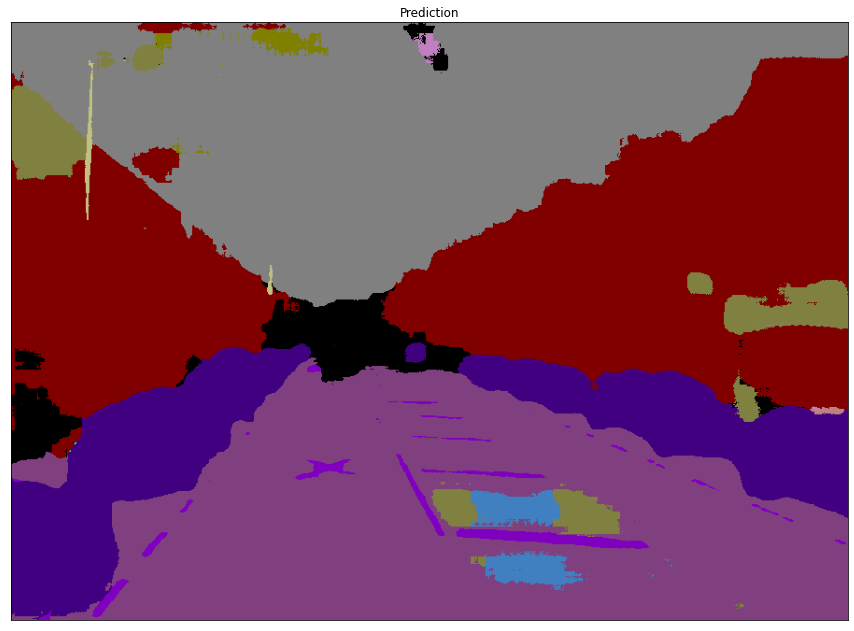

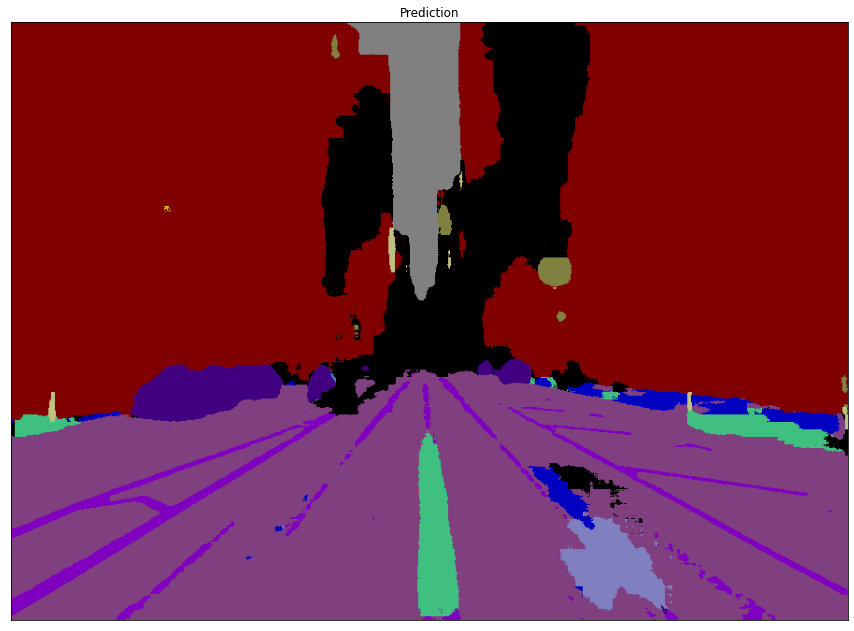

In [22]:
name = ["/content/drive/My Drive/CamVid/City_Road_Cardiff.jpg",
        "/content/drive/My Drive/CamVid/City-Road-in-Cardiff2.jpg",
        "/content/drive/My Drive/CamVid/Road US.jpg"]
for inp_image in name:

  prd=get_predicted_image(imageio.imread(inp_image), get_image_labels(inp_image))
  plot_imgs([prd], ["Prediction"], (15, 15))

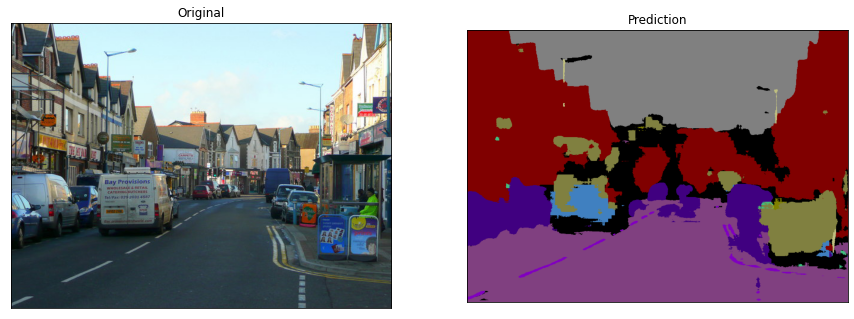

In [23]:
inp_image = "/content/drive/My Drive/CamVid/City_Road_Cardiff.jpg"

original = imageio.imread(inp_image)
predicted = get_predicted_image(original, get_image_labels(inp_image))
   
plot_imgs([original, predicted], ["Original", "Prediction"], (15, 15))

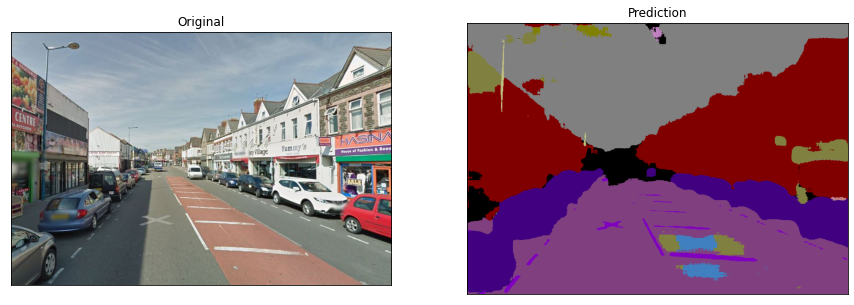

In [24]:
inp_image = "/content/drive/My Drive/CamVid/City-Road-in-Cardiff2.jpg"

original = imageio.imread(inp_image)
predicted = get_predicted_image(original, get_image_labels(inp_image))
   
plot_imgs([original, predicted], ["Original", "Prediction"], (15, 15))

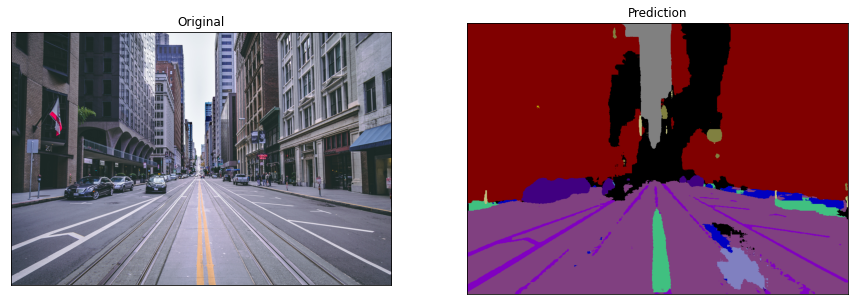

In [25]:
inp_image = "/content/drive/My Drive/CamVid/Road US.jpg"

original = imageio.imread(inp_image)
predicted = get_predicted_image(original, get_image_labels(inp_image))
   
plot_imgs([original, predicted], ["Original", "Prediction"], (15, 15))

### Segment a selected group of labels

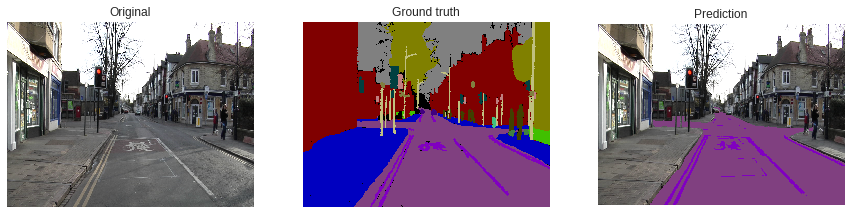

In [ ]:
name = "Seq05VD_f01800"

inp_image = "data/CamVid/701_StillsRaw_full/" + name + ".png"
tru_image = "data/CamVid/LabeledApproved_full/" + name + "_L.png"

original = scipy.misc.imread(inp_image)
truth = scipy.misc.imread(tru_image)
predicted = get_predicted_image(original, get_image_labels(inp_image), [11, 12, 18, 19]) # Only road labels

plot_imgs([original, truth, predicted], ["Original", "Ground truth", "Prediction"], (15, 15))

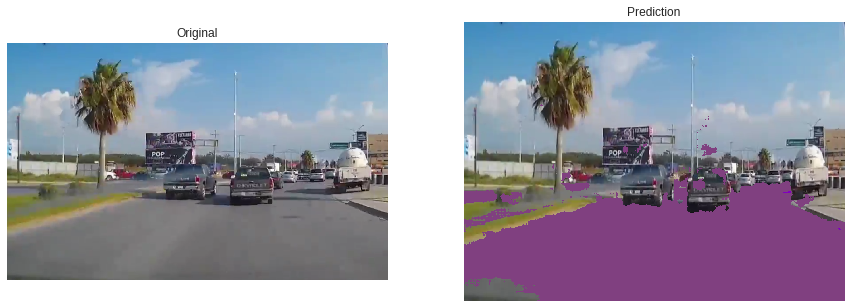

In [ ]:
inp_image = "data/testimage2.png"

original = scipy.misc.imread(inp_image)
predicted = get_predicted_image(original, get_image_labels(inp_image), [11, 12, 18, 19]) # Only road labels
   
plot_imgs([original, predicted], ["Original", "Prediction"], (15, 15))

### Inference on video

In [ ]:
import glob
import os 
import cv2

def get_frame_rate(video):
    video = cv2.VideoCapture(video);
    # Find OpenCV version
    (major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
    if int(major_ver)  < 3 :
        fps = video.get(cv2.cv.CV_CAP_PROP_FPS)
        print("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(int(fps)))
    else :
        fps = video.get(cv2.CAP_PROP_FPS)
        print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(int(fps)))
    video.release();
    return int(fps)
    
def process_video(video, path_to_save):
    cap = cv2.VideoCapture(video)
    print("Number of frames: ", int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
    ret, frame = cap.read()
    cont = 0
    while ret:
        if cont > 17100 and cont < 17710:
          #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
          prediction = get_predicted_image(frame, get_image_labels(frame), [11, 12, 18, 19]) # Only road labels
          cv2.imwrite(path_to_save + str(cont) + ".png", prediction)
        cont += 1
        ret, frame = cap.read()
    print("Video processed.")

def make_video(outvid, images=None, fps=30, size=None, is_color=True, format="FMP4"):
    fourcc = cv2.VideoWriter_fourcc(*format)
    vid = None
    for image in images:
        if not os.path.exists(image):
            raise FileNotFoundError(image)
        img = cv2.imread(image)
        if vid is None:
            if size is None:
                size = img.shape[1], img.shape[0]
            vid = cv2.VideoWriter(outvid, fourcc, float(fps), size, is_color)
        if size[0] != img.shape[1] and size[1] != img.shape[0]:
            img = cv2.resize(img, size)
        vid.write(img)
    vid.release()
    return vid
    
def detect_on_video(video, out_path, fps):
    # Process video to get all the frames with detections
    process_video(video, out_path)
    # Get processed frames and order by name
    images = list(glob.iglob(os.path.join(out_path, '*.png')))
    images = sorted(images, key=lambda x: float(os.path.split(x)[1][:-3]))
    # Create the video from processed frames
    make_video(out_path+"output.mp4", images, fps)
    print("Video: "+ out_path +" output.mp4 it's ready")

video = './../YOLO/images/timelapse.mp4'
path = './data/processed/'

fps = get_frame_rate(video)
detect_on_video(video, path, fps+1)

Frames per second using video.get(cv2.CAP_PROP_FPS) : 29
Number of frames:  22339
Video processed.
Video: ./data/processed/ output.mp4 it's ready


### Video output (converted as GIF) 

![Video-output](/images/outputgif.gif)